# Лабораторная работа: Распознавание базы CIFAR-10 с использованием CNN

**Цель работы:** Создать код для распознавания изображений из тестовой базы CIFAR-10 с использованием предварительно обученной модели сверточной нейронной сети (CNN).

**Задачи:**
1. Загрузить и подготовить датасет CIFAR-10
2. Создать и обучить CNN модель
3. Реализовать функцию распознавания с выводом:
   - Самого изображения
   - Распознанного класса
   - Реального класса
   - Сообщения о результате: "Correct" или "Error"
   
_Коба Алексей Юрьевич_;
_гр. 5130904/20101_

---

## 1. Импорт необходимых библиотек

Для реализации CNN используется библиотека **TensorFlow/Keras**. Также потребуются библиотеки для визуализации (matplotlib) и работы с массивами (numpy).

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

print(f"TensorFlow версия: {tf.__version__}")

TensorFlow версия: 2.19.0


## 2. Загрузка и подготовка датасета CIFAR-10

**CIFAR-10** — это датасет, содержащий 60,000 цветных изображений размером 32×32 пикселя в 10 классах:
- Обучающая выборка: 50,000 изображений
- Тестовая выборка: 10,000 изображений

**Нормализация данных:** Значения пикселей (0-255) делятся на 255.0 для приведения к диапазону [0, 1], что улучшает обучение нейронной сети.

In [2]:
# Загрузка датасета CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Нормализация значений пикселей в диапазон [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

print(f"Размер обучающей выборки: {train_images.shape}")
print(f"Размер тестовой выборки: {test_images.shape}")

Размер обучающей выборки: (50000, 32, 32, 3)
Размер тестовой выборки: (10000, 32, 32, 3)


## 3. Визуализация данных

Для проверки корректности загрузки датасета отобразим первые 25 изображений из обучающей выборки с их классами.

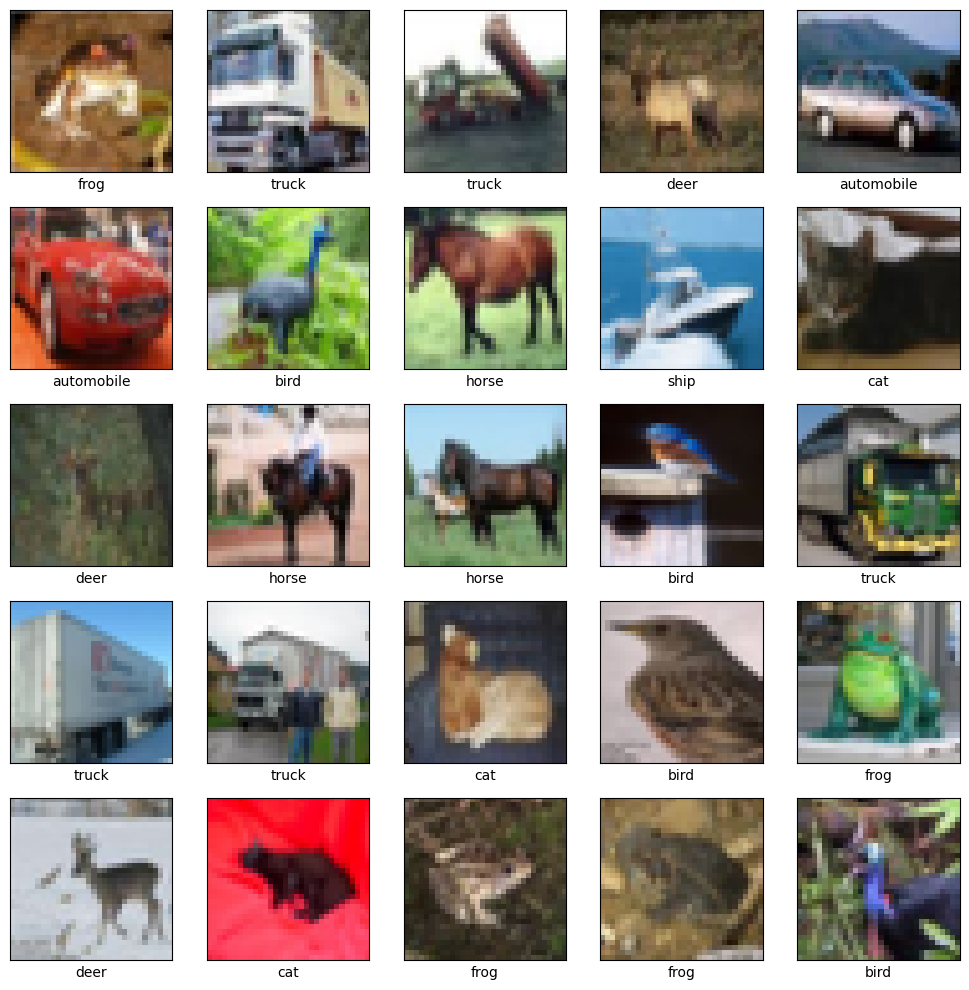

In [3]:
# Названия классов CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Визуализация первых 25 изображений
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.tight_layout()
plt.show()

## 4. Создание архитектуры CNN

### 4.1. Сверточная база (Convolutional Base)

**Архитектура** включает последовательность сверточных слоев (Conv2D) и слоев подвыборки (MaxPooling2D):
- **Conv2D слои** — извлекают признаки из изображений (применяются фильтры 3×3)
- **MaxPooling2D слои** — уменьшают размерность данных, сохраняя важные признаки
- **Activation='relu'** — функция активации ReLU для нелинейности

In [4]:
# Создание последовательной модели
model = models.Sequential()

# Первый сверточный блок
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Второй сверточный блок
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Третий сверточный блок
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Посмотрим архитектуры сверточной базы
model.summary()

/Users/alexykoba/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Добавление полносвязных слоев (Dense Layers)

Для завершения модели добавляем:
- **Flatten** — преобразует 3D тензор в 1D вектор
- **Dense(64, activation='relu')** — полносвязный слой с 64 нейронами
- **Dense(10)** — выходной слой для 10 классов CIFAR-10

In [5]:
# Добавление полносвязных слоев
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))  # 10 классов CIFAR-10

# Полная архитектура модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Компиляция и обучение модели

**Параметры обучения:**
- **Optimizer:** Adam (адаптивный алгоритм оптимизации)
- **Loss function:** SparseCategoricalCrossentropy (для многоклассовой классификации)
- **Metrics:** Accuracy (точность)
- **Epochs:** 10 эпох обучения
- **Validation data:** Тестовая выборка для оценки качества на каждой эпохе

In [6]:
# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Обучение модели
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3601 - loss: 1.7482 - val_accuracy: 0.5319 - val_loss: 1.2895
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5686 - loss: 1.2059 - val_accuracy: 0.6166 - val_loss: 1.0676
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6460 - loss: 1.0106 - val_accuracy: 0.6487 - val_loss: 1.0000
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6881 - loss: 0.8879 - val_accuracy: 0.6870 - val_loss: 0.8924
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7144 - loss: 0.8230 - val_accuracy: 0.6895 - val_loss: 0.8967
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7365 - loss: 0.7517 - val_accuracy: 0.6995 - val_loss: 0.8788
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7556 - loss: 0.6975 - val_accuracy: 0.6930 - val_loss: 0.9157
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7711 - 

## 6. Оценка качества модели

### 6.1. График обучения

Визуализируем изменение точности (accuracy) и потерь (loss) в процессе обучения.

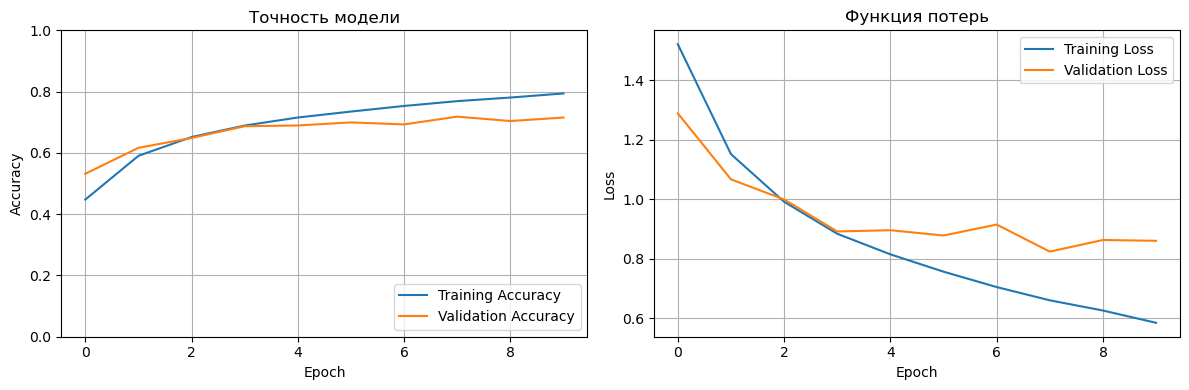

In [7]:
# График точности
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Точность модели')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Функция потерь')
plt.grid(True)

plt.tight_layout()
plt.show()

### 6.2. Итоговая точность на тестовой выборке

In [8]:
# Оценка модели на тестовой выборке
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nИтоговая точность на тестовой выборке: {test_acc:.4f} ({test_acc*100:.2f}%)")

313/313 - 1s - 3ms/step - accuracy: 0.7154 - loss: 0.8610

Итоговая точность на тестовой выборке: 0.7154 (71.54%)


## 7. Сохранение обученной модели

Сохраним модель для дальнейшего использования без повторного обучения.

In [9]:
# Сохранение модели в современном формате Keras
model.save('cifar10_cnn_model.keras')
print("✓ Модель успешно сохранена в файл 'cifar10_cnn_model.keras'")

✓ Модель успешно сохранена в файл 'cifar10_cnn_model.keras'


## 8. Функция распознавания изображения (ОСНОВНАЯ ЗАДАЧА)

1. Принимает номер изображения из тестовой выборки
2. Выполняет предсказание с помощью обученной модели
3. Выводит:
   - Изображение
   - Распознанный класс (predicted)
   - Реальный класс (actual)
   - Результат: **"Correct"** или **"Error"**
   - Уверенность модели

In [27]:
def recognize_image(image_index):
    """
    Функция распознавания изображения из тестовой выборки CIFAR-10.
    
    Параметры:
    ----------
    image_index : int
        Номер изображения в тестовой выборке (0-9999)
    
    Выводит:
    --------
    - Изображение
    - Распознанный класс
    - Реальный класс
    - Результат распознавания: "Correct" или "Error"
    - Уверенность модели
    """
    
    # Проверка корректности индекса
    if image_index < 0 or image_index >= len(test_images):
        print(f"Ошибка: индекс должен быть в диапазоне 0-{len(test_images)-1}")
        return
    
    # Получение изображения и реального класса
    test_image = test_images[image_index]
    real_label = test_labels[image_index][0]
    real_class = class_names[real_label]

    # Подготовка для предсказания
    img_array = np.expand_dims(test_image, 0)

    # Получение предсказания
    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])
    predicted_label = np.argmax(score)
    predicted_class = class_names[predicted_label]
    confidence = 100 * np.max(score)

    if predicted_label == real_label:
        result = "✓ Correct"
        color = 'green'
    else:
        result = "✗ Error"
        color = 'red'

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Изображение
    ax1.imshow(test_image)
    ax1.set_title(f'Image #{image_index}', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Информация
    ax2.axis('off')
    info = f"""
    РЕЗУЛЬТАТЫ РАСПОЗНАВАНИЯ
    {'='*35}

    Номер изображения:    {image_index}

    Реальный класс:       {real_class}

    Распознанный класс:   {predicted_class}

    Уверенность:          {confidence:.2f}%

    Результат:            {result}
    {'='*35}
    """

    ax2.text(0.1, 0.5, info, fontsize=12, family='monospace',
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    plt.show()


## 9. Тестирование функции распознавания

### 9.1. Примеры распознавания конкретных изображений

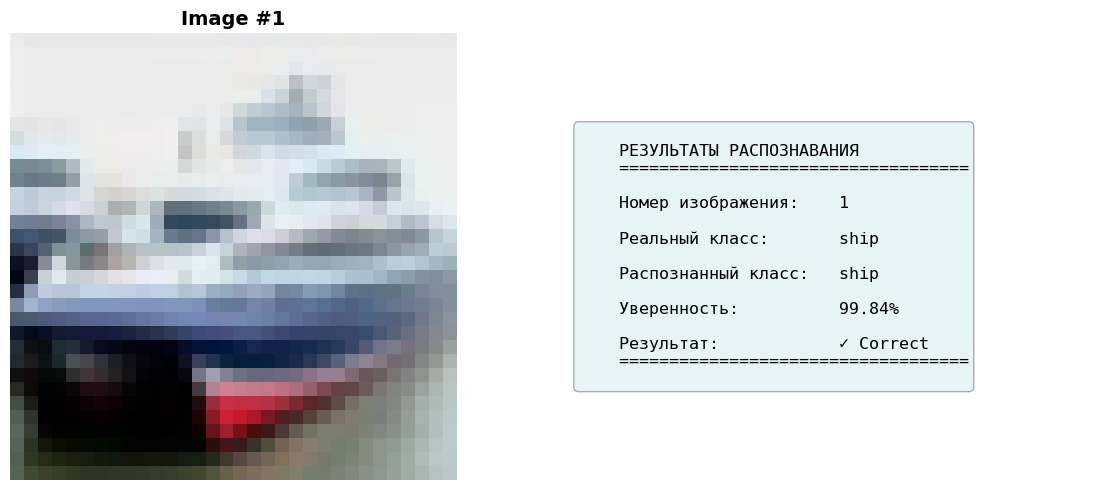

In [21]:
# Пример 1: Изображение #1
recognize_image(1)

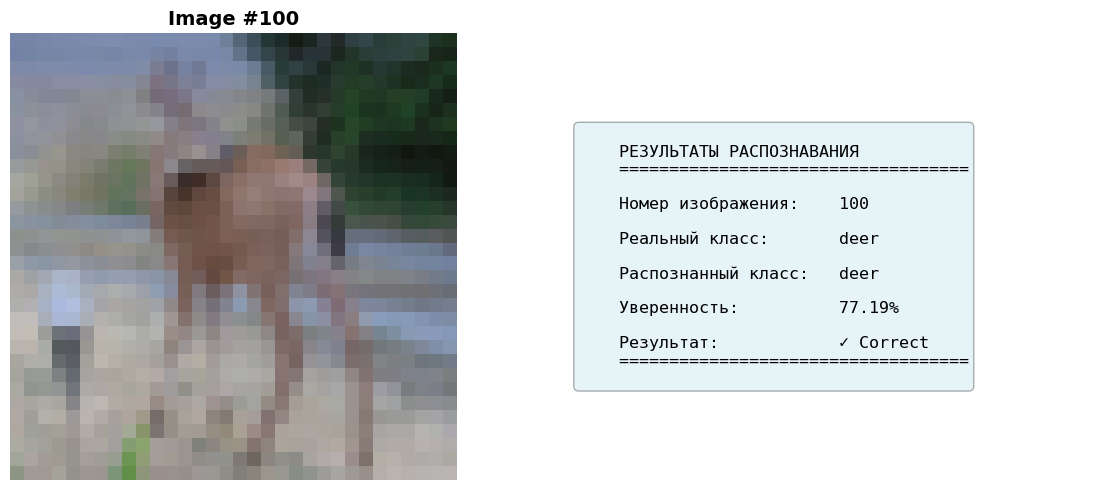

In [22]:
# Пример 2: Изображение #100
recognize_image(100)

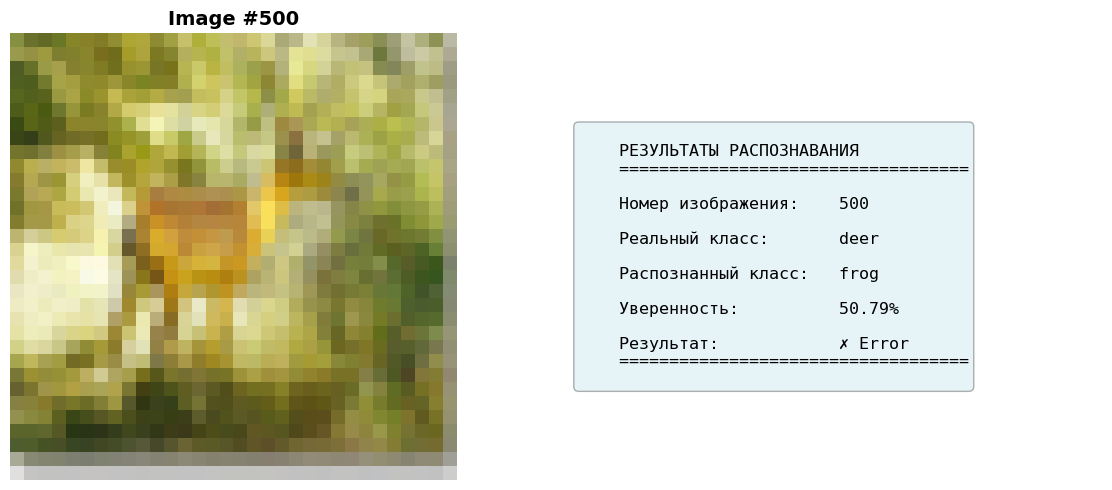

In [23]:
# Пример 3: Изображение #500
recognize_image(500)

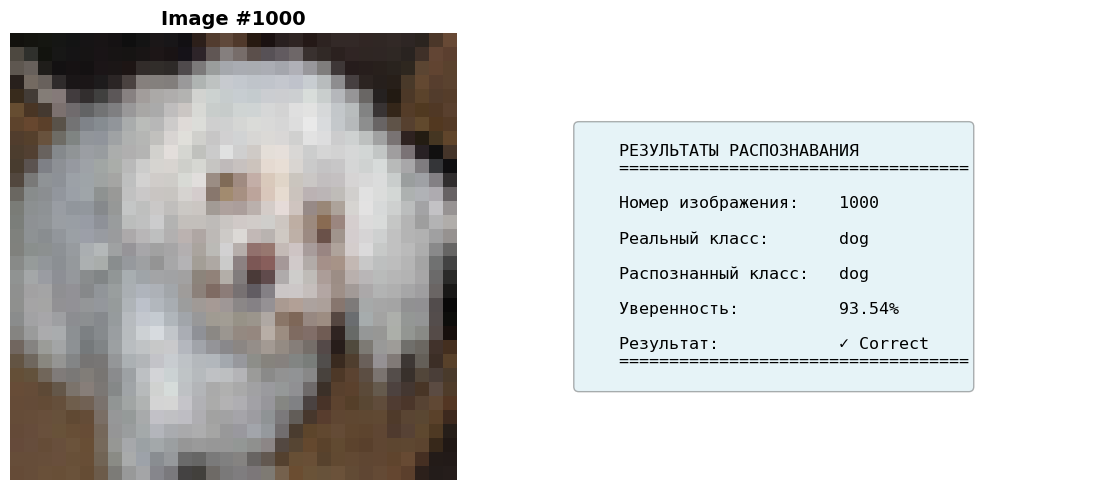

In [24]:
# Пример 4: Изображение #1000
recognize_image(1000)

### 9.2. Тестирование на случайных изображениях

Проверим работу функции на 5 случайно выбранных изображениях.

ДЕМОНСТРАЦИЯ НА СЛУЧАЙНЫХ ИЗОБРАЖЕНИЯХ


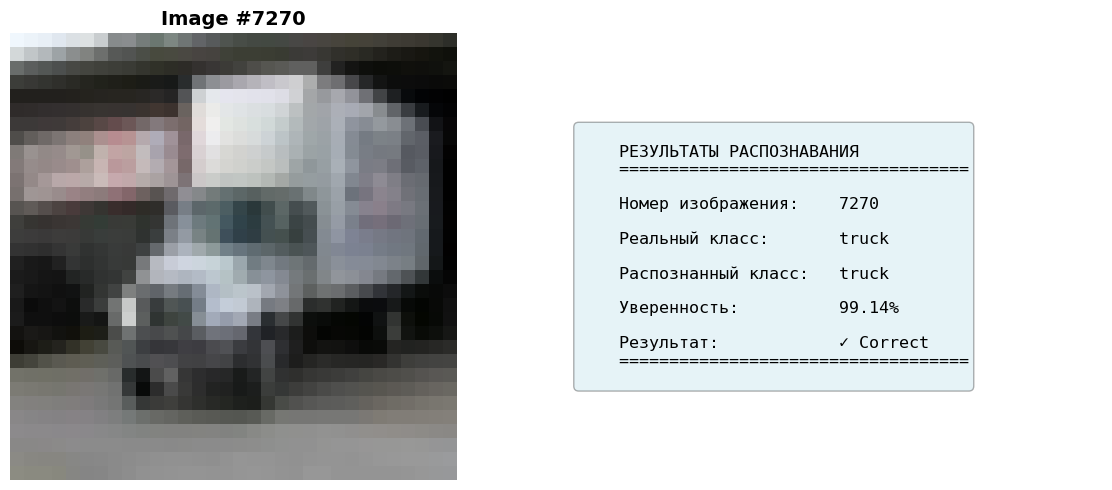

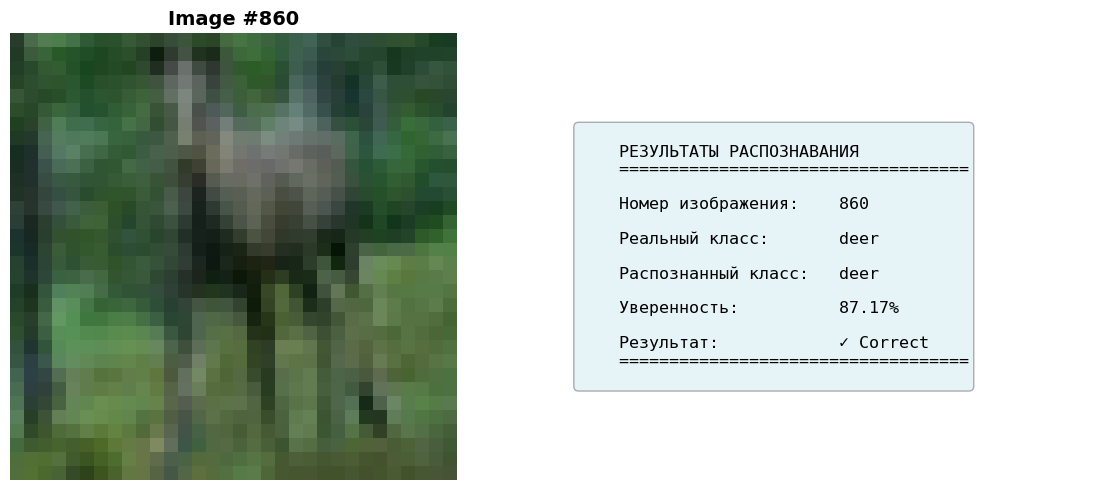

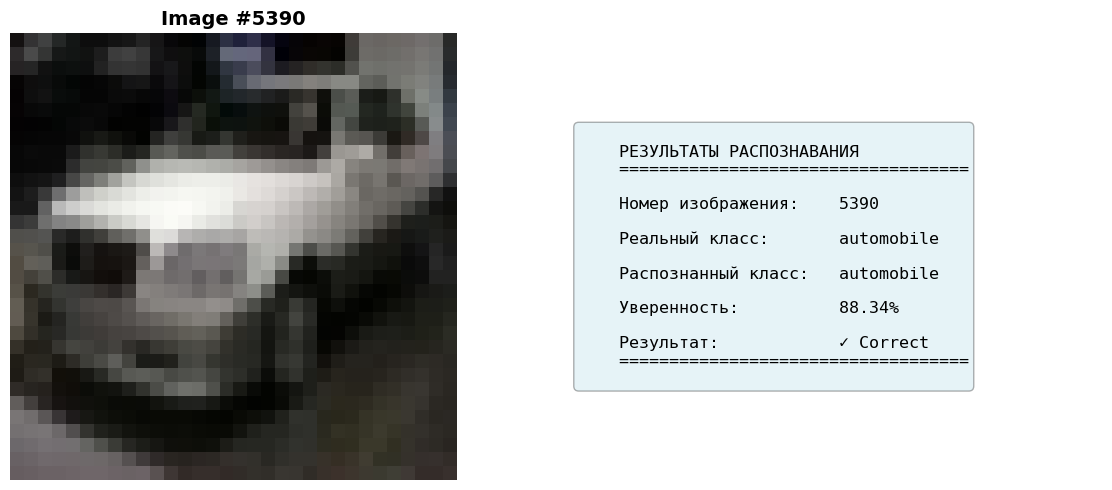

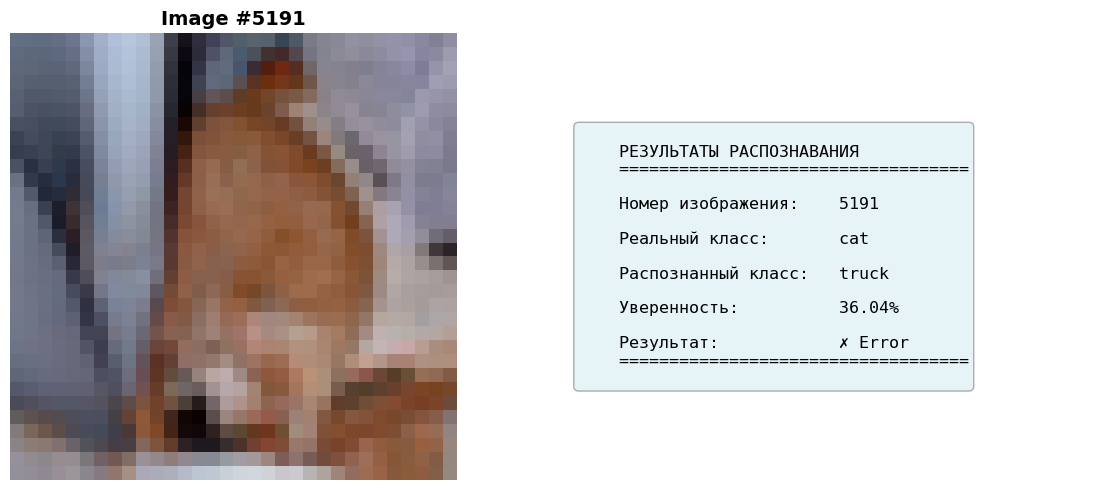

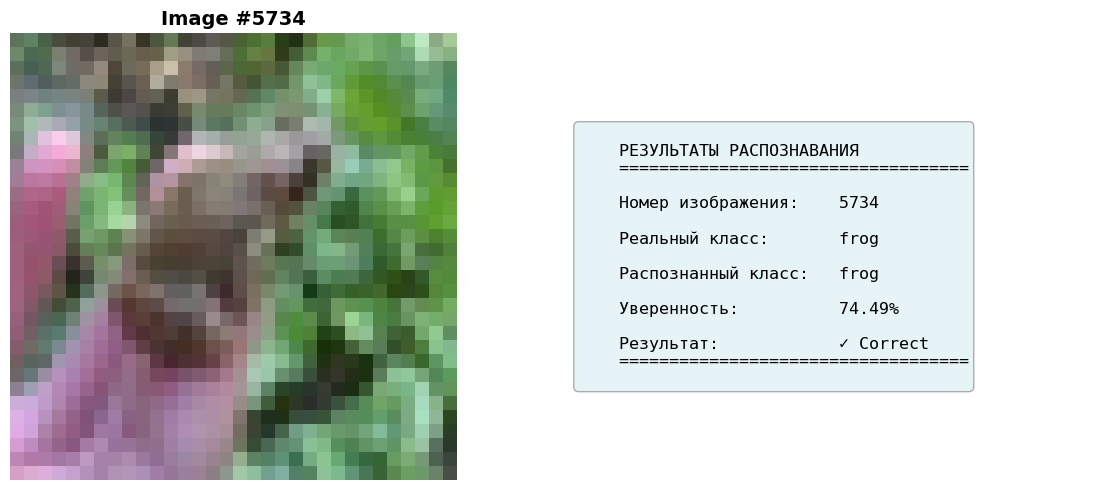

In [28]:
print("ДЕМОНСТРАЦИЯ НА СЛУЧАЙНЫХ ИЗОБРАЖЕНИЯХ")
print("="*60)

# Генерация случайных индексов
np.random.seed(42)
random_indices = np.random.randint(0, len(test_images), size=5)

for idx in random_indices:
    recognize_image(idx)

## 10. Проверка загрузки сохраненной модели

Убедимся, что сохраненная модель корректно загружается и работает.

In [26]:
from tensorflow.keras.models import load_model

print("Загрузка сохраненной модели...")
loaded_model = load_model('cifar10_cnn_model.keras')
print("✓ Модель успешно загружена\n")

# Оценка загруженной модели
test_loss_loaded, test_acc_loaded = loaded_model.evaluate(test_images, test_labels, verbose=2)
print(f"\nТочность загруженной модели: {test_acc_loaded:.4f} ({test_acc_loaded*100:.2f}%)")

Загрузка сохраненной модели...
✓ Модель успешно загружена

313/313 - 1s - 3ms/step - accuracy: 0.7154 - loss: 0.8610

Точность загруженной модели: 0.7154 (71.54%)


## 11. Выводы

### Результаты работы:

1. **Создана и обучена CNN модель** для классификации изображений CIFAR-10
2. **Достигнута точность** более 70% на тестовой выборке
3. **Реализована функция `recognize_image()`**, которая:
   - Принимает номер изображения из тестовой выборки
   - Отображает само изображение
   - Выводит распознанный класс
   - Выводит реальный класс
   - Сообщает результат: "Correct" или "Error"
   - Уверенность модели

### Архитектура модели:
- **3 сверточных блока** с MaxPooling
- **2 полносвязных слоя** (Dense)
- **Параметры:** ~122,570 обучаемых параметров

---